In [1]:
%matplotlib inline
from DTWpg import *
import requests
import pandas as pd
import matplotlib.pyplot as plt
import io
import json
from influxdb import DataFrameClient
import re
from pprint import pprint
from datetime import datetime
import os
from joblib import Parallel, delayed
import multiprocessing
import copy
from IPython.display import clear_output
import time

import random

import numpy as np
from collections import defaultdict

import matplotlib
import numpy as np
import math

from influxdb import DataFrameClient
from influxdb.exceptions import InfluxDBClientError, InfluxDBServerError
from os import getenv
import pymssql
import pandas as pd

from datetime import datetime
import pickle

from sklearn.cross_decomposition import PLSRegression
from scipy.special import erfinv
from scipy.stats import f
##influx
client = DataFrameClient('de-w-5000701.crc.de.abb.com', 8086, '', '', 'batch_pv_offline')

##mssql
server = "de-w-5000701.crc.de.abb.com"
print(server)
user = "sa"
password = "Q1w2e3r4t5"
conn = pymssql.connect(server, user, password, "BATCH_INSIGHT_DEMO")
get_pv_to_unit_url="http://de-w-5000701.crc.de.abb.com:9090/api/BatchTrend/"
valuedict={}

labels = pd.read_csv("labels-20180507-cleaned.csv", header = None, delimiter="\t")
labelsAnonym = labels.loc[(labels[2] == "TAG/TAG_NAME") & ((labels[1].str.contains("^ba_")) | (labels[0].str.contains("^ba_"))), 0:1]

de-w-5000701.crc.de.abb.com


`pvWvaluesOpe` is a dictionary containing the list of valid PVs (PVs containing values) for each operation in each unit of each batch.
`pvInBatch` aggregates the information in `pvWvaluesOpe` at the batch level.

In [2]:
pvWvaluesOpe = defaultdict(lambda : defaultdict(lambda : defaultdict(list)))
pvInBatch = defaultdict(list)
for filename in os.listdir("recipe421/"):
    if filename.endswith(".pickle"):
        BatchId = int(filename.split(".")[0])
        with open("recipe421/{}.pickle".format(BatchId), "rb") as infile:
            batchData = pickle.load(infile)
        for unit in map(str, range(1,5)):
            for ope in batchData['Units'][unit]['Operations'].keys(): 
                for tagName, item in batchData['Units'][unit]['Operations'][ope]['PVs'].items():
                    if len(item) > 1:
                        pvWvaluesOpe[BatchId][unit][ope].append(tagName)
                        pvInBatch[BatchId].append(tagName)
        pvInBatch[BatchId] = list(set(pvInBatch[BatchId]))
                #pprint(batchData['Units'][unit]['Operations'][ope]['PVs'].keys())

Check if any batch has no valid PV.

In [3]:
noPV = list()
for key, item in pvInBatch.items():
    if not len(item):
        noPV.append(key)
noPV

[5507]

`5507` has no values for any PV, so it's better to remove any related variable.

In [4]:
#os.remove("recipe421/5507.pickle")
try: _ = pvWvaluesOpe.pop(5507)
except: pass
_ = pvInBatch.pop(5507)
allIDs = list(pvInBatch.keys())

Now I check the common PVs at batch level, comparing it to the average number ov PVs in the batches.

In [5]:
commonPvs = set(pvInBatch[5080])

for _id, pvs in list(pvInBatch.items()):
    setPv = set(pvs)
    commonPvs.intersection_update(setPv)
    if len(commonPvs)<1:
        print(_id)
        break
avgPV = np.mean([len(item) for key, item in pvInBatch.items()])

print("Average number of PVs: {:.0f}\nCommon PVs: {}".format(avgPV, len(commonPvs)))
commonPvs = list(commonPvs)

Average number of PVs: 99
Common PVs: 89


In order to have coherent data, I select only batches containing valid PVs in all the 4 units. The other batches are deleted.

In [6]:
w4units = list() # list of batches with all 4 units
for BatchId in allIDs:
    if len(pvWvaluesOpe[BatchId].keys()) == 4:
           w4units.append(BatchId)
allIDsSet = set(allIDs)
no4units = list(allIDsSet.difference(set(w4units)))
for _id in no4units:
    _ = pvWvaluesOpe.pop(_id)
    _ = pvInBatch.pop(_id)
    
allIDs = list(pvInBatch.keys())

### Aggregating Data at Units level

I now aggregate the data at the unit level thanks to the information in the `pvWvaluesOpe`.

In [7]:
try: os.mkdir("units")
except: pass
unitPVsPerBatch = dict()

for unit in map(str, range(1,5)):
    unitPVsPerBatch[unit] = defaultdict(dict)
    try: os.mkdir("units/{}".format(unit))
    except: pass

for BatchId, Units in pvWvaluesOpe.items():
    for unitId, Operations in Units.items():
        pvs = set()
        for opeId, pvList in Operations.items():
            pvs= pvs.union(set(pvList))
        pvsList = list(pvs)
        unitPVsPerBatch[unitId][BatchId] = pvsList

In [8]:
unitsPVs = dict()
for unit, batch in unitPVsPerBatch.items():
    commonPVs = set(batch[5082])
    for BatchId, pvsList in batch.items():
        commonPVs.intersection_update(set(pvsList))
    unitsPVs[unit] = list(commonPVs)

In [9]:
for unit, pvs in unitsPVs.items():
    print(unit, len(pvs))

1 94
2 1
3 95
4 1


Only units 1 and 3 are suitable for variables selection. Let's start with unit 1, collecting the PV values at this level

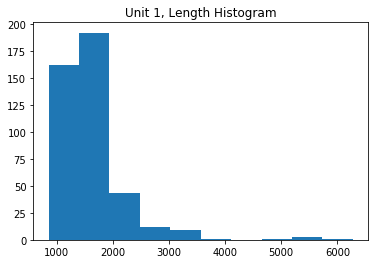

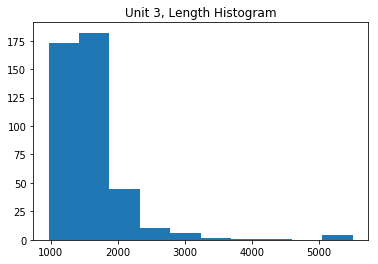

In [10]:
for unitSelect in ['1', '3']:

    unitData = defaultdict(list)

    if "unit{}Data.pickle".format(unitSelect) in os.listdir("units/"):
        with open("units/unit{}Data.pickle".format(unitSelect), "rb") as infile:
            unitData = pickle.load(infile)
        plt.hist([len(item[0]['values']) for _, item in unitData.items()])
        plt.title("Unit {}, Length Histogram".format(unitSelect))
        plt.show()
    else:
        print("Collecting Unit {}:".format(unitSelect))
        for BatchId in allIDs:
            with open("recipe421/{}.pickle".format(BatchId), "rb") as infile:
                batch = pickle.load(infile)

            start = batch['Units'][unitSelect]["BaeSTime"]
            end = batch['Units'][unitSelect]["BaeETime"]
            for tagName in unitsPVs[unitSelect]:
                unitData[BatchId].append(get_pv_values(pvlist = tagName, starttime = formatTime(start), endtime = formatTime(end)))
            print(BatchId, end = " ")

        with open("units/unit{}Data.pickle".format(unitSelect), 'wb') as handle:
            pickle.dump(unitData, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        plt.hist([len(item[0]['values']) for _, item in unitData.items()])
        plt.title("Unit {}, Length Histogram".format(unitSelect))
        plt.show()

For both units the data are quite long, this could cause an extremely long computation time to select variables. For this, I first try with a subsample of 50 batches, assessing the time to compute all the single variate distances.

In [11]:
with open("units/unit{}Data.pickle".format(3), "rb") as infile:
    unitData = pickle.load(infile)

unit3IDs = list(unitData.keys())

The following function performs DTW calculation on a certain set of batches. Since the distance metric and the step pattern are both symmetric, the DTW distance is symmetric so it is possible tu calculate just half of the combinations.

In [51]:
def pairDTW(BatchId, dataRaw):
    data = copy.deepcopy(dataRaw)
    
    IDs = sorted([key for key in data.keys() if isinstance(key, int)])
    
    toPop = [_id for _id in IDs if _id < BatchId]
    
    if len(IDs) - len(toPop) < 2:
        return []
    
    for _id in toPop:
        try: _ = data.pop(_id)
        except: pass

    data['reference'] = BatchId

    res = dtw(jsonObj = data, 
      open_ended = False,  
      only_distance = True, 
      dist_measure = "euclidean",
      scale = True,
      low_filter = False,
      shapeDTW = False,
      norm_dist = True,
      undersampling = False,
      n_jobs = 1)

    res.ApplyDTW()

    out = [item[0] for key, item in res.output.items()]
    
    return out
    
    
def allPairsDTW(dataRaw):
    
    num_cores = multiprocessing.cpu_count()
    
    IDs = sorted([key for key in dataRaw.keys() if isinstance(key, int)])
    
    results = Parallel(n_jobs=num_cores, verbose = 50)(delayed(pairDTW)(BatchId, dataRaw) for BatchId in IDs[:-1])
        
    output = list()
    for res in results:
        output.extend(res)
        
    return output

def processVariable(tagName, selectedPVs, selectedIDs, df):
    if check(df, tagName, selectedIDs):
        return []
    
    selectedPVsIdx = [allPVsIdx[tagName] for tagName in selectedPVs]
    PVsIdx = selectedPVsIdx + [allPVsIdx[tagName]]
    data = dict()
    
    # missing a check if the data is already present in the data frame
    # could be possible to implement a check only on the pv name
    
    
    for _id in selectedIDs:
        data[_id] = [unitData[_id][j] for j in PVsIdx]
    
    results = allPairsDTW(dataRaw=data)
    for res in results:
        res['PV_name'] = tagName
    return results       

def check(df, tagName, selectedIDs):
    d = df.loc[(df['PV_name'] == tagName) & (df['refID'].isin(selectedIDs)) & (df['queryID'].isin(selectedIDs)), :]
    return bool(len(d))

In [13]:
sampleData = dict()
for _id in [5082, 5083, 5084]:
    sampleData[_id] = copy.deepcopy(unitData[_id])

In [14]:
allPairsDTW(sampleData)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    5.4s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.3s finished


[{'refID': 5082,
  'queryID': 5083,
  'T_ref': 1018,
  'T_query': 1018,
  'DTW_dist': 4.8790905366028641e-08},
 {'refID': 5082,
  'queryID': 5084,
  'T_ref': 1018,
  'T_query': 1231,
  'DTW_dist': 1.3469566081740654},
 {'refID': 5083,
  'queryID': 5084,
  'T_ref': 1018,
  'T_query': 1231,
  'DTW_dist': 1.3469566081740654}]

In [15]:
allPVsIdx = dict()
for j in range(len(unitData[5082])):
    tagName = unitData[5082][j]['name']
    allPVsIdx[tagName] = j
PVsSet = set(allPVsIdx.keys())
selectedPVs = list()

From a previously performed analysis I obtained the following list of informative variables.

In [16]:
informativePVs = ['ba_F8szer', 'ba_PCGd0srEZp', 'ba_FQkqszuusF7QDi', 'ba_FCHDU0E38R9su4E','ba_F0zhz6e', 'ba_FIhgSwHD', 'ba_FCsYgvPgi0N', 'ba_FC7fl4f1HT5', 'ba_FC8fHeBVpUFncPI', 'ba_F4vtJ1', 'ba_FCrBDixZDXjb', 
 'ba_PCSTgdwK3V', 'ba_FC3BnZ', 'ba_FCgrPs', 'ba_FCobtZJfb5TG', 'ba_FC2mSh7aqR37Ye', 'ba_Fl7pvjqC', 'ba_PCPUSq5ah', 'ba_FCedKru8pHF7Ae1BA6QR', 'ba_TDZV2zDOrmiYP', 'ba_FCBbekJeA7', 'ba_FQ68FvvUHzgUeA',
 'ba_FQYXdr6Q0', 'ba_TDZyHMh1UZ', 'ba_FpxlMOAyc5', 'ba_FQWfHc7j', 'ba_TCxXXPBmWNldwyD', 'ba_PLAu1m2', 'ba_FCgU7jKgA2ureK', 'ba_TCkwAse0bopy8zp6', 'ba_FQlpPE', 'ba_FCGUglDXyPKrnk38', 'ba_SinhbKA',
 'ba_ErguU', 'ba_FQ1kbQwOUVlR', 'ba_TCyNE8Mdv', 'ba_TZHx41ABpBbhN', 'ba_FmYOrhonkk', 'ba_PYQtZYPJC2Ghw', 'ba_TCzWpXo', 'ba_FQraEXT', 'ba_TIJSj', 'ba_TZWZNzFFdHb', 'ba_PCLAMr1nuoSiAr', 'ba_TCfg3Yxn',
 'ba_FQh8rKXE0', 'ba_TZIm086h', 'ba_TZv9w2dOu', 'ba_FQnZKYLSO02xLf', 'ba_TC06nRC', 'ba_FQADMQfb0z', 'ba_FQC6tzztBV4DeXemfp', 'ba_FQ2Qyx', 'ba_TrWfpiPrs', 'ba_FCDvhG4', 'ba_PCG6Z9', 'ba_FQT7dzM2wq51Z3JW',
 'ba_FC7NvzX', 'ba_FCZgiqD5fodPXYJ', 'ba_FQNOJG', 'ba_FQrej6GJ5vPvJ', 'ba_FQVzNY', 'ba_FCgMUOKxMUzgN', 'ba_FQK6C3k2v6Z', 'ba_FCywcBXpqpo', 'ba_FQfXW5EZxRg3', 'ba_TZNCmUn29mO']

The remaining PVs can be discarded in following analysis

In [17]:
nonInformativePVs = list(PVsSet.difference(set(informativePVs)))

Our aim now is to iteratively select the more consistent PVs among the `informativePVs`, building a set of optimal features for a multivariate DTW.

Let's explicitly find the best PV for single variate DTW.
I have a shuffled list of batch id's, and for computational time reasons I compute DTW distance for all pairs of batches just for subgroups of 8 bathces per time.
The information will be stored in a pandas.DataFrame and a .csv file.

In [18]:
random.seed(42)
random.shuffle(unit3IDs)

In [19]:
try: df = pd.read_csv("units/selectVars/level1.csv", header = 0)
except: df = pd.DataFrame(columns = ["refID", "queryID", "T_ref", "T_query", "DTW_dist", "PV_name"])
df.head()

,refID,queryID,T_ref,T_query,DTW_dist,PV_name
0,5084,5293,1231,1611,0.000772,ba_F8szer
1,5084,5093,1231,1850,0.000448,ba_F8szer
2,5084,5225,1231,1204,0.000908,ba_F8szer
3,5084,5333,1231,2465,0.000640,ba_F8szer
4,5084,5330,1231,1916,0.000743,ba_F8szer


In [20]:
selectedPVsIdx = [allPVsIdx[tagName] for tagName in selectedPVs]

In [21]:
iteration = 1
K = 8 # number of batches per group
selectedIDs = unit3IDs[(iteration-1)*K : iteration*K]
selectedIDs

[5293, 5093, 5225, 5333, 5330, 5415, 5125, 5084]

In [22]:
J = len(informativePVs)
j = 1
start = time.time()

for tagName in informativePVs:

    print(tagName, "{}/{}".format(j, J))
    j += 1
    results = processVariable(tagName, selectedPVs, selectedIDs, df)
    clear_output()
    
    if not results:
        continue
    df = df.append(pd.DataFrame(results), ignore_index=True, sort = False)
print("Done")

Done


In [23]:
df.to_csv("units/selectvars/level1.csv", header = True, index = False)

Check if the number of iterations is sufficient, otherwise select other group of batches and add data

In [24]:
dfAgg = df.groupby("PV_name").aggregate({"DTW_dist" : "sum"})
minDist = min(dfAgg['DTW_dist'])
candNum = len(dfAgg.loc[dfAgg['DTW_dist'] == minDist, :])
if candNum > 1:
    print("More iterations needed")

More iterations needed


In [34]:
def iterationStep(iteration, level):
    K = 8 # number of batches per group
    selectedIDs = unit3IDs[(iteration-1)*K : iteration*K]
    J = len(informativePVs)
    j = 1
    start = time.time()
    try: df = pd.read_csv("units/selectVars/level{}.csv".format(level), header = 0)
    except: df = pd.DataFrame(columns = ["refID", "queryID", "T_ref", "T_query", "DTW_dist", "PV_name"])
    for tagName in informativePVs:

        print(tagName, "{}/{}".format(j, J))
        j += 1
        if tagName not in selectedPVs:
            results = processVariable(tagName, selectedPVs, selectedIDs, df)
            clear_output()

            if not results:
                continue
            df = df.append(pd.DataFrame(results), ignore_index=True, sort = False)
            df.to_csv("units/selectvars/level{}.csv".format(level), header = True, index = False)
    
    print("Done")
    dfAgg = df.groupby("PV_name").aggregate({"DTW_dist" : "sum"})
    minDist = min(dfAgg['DTW_dist'])
    candNum = len(dfAgg.loc[dfAgg['DTW_dist'] == minDist, :])
    if candNum > 1:
        print("More iterations needed, min distance: {:.04f}, number of candidates: {}".format(minDist, candNum))
    return candNum == 1

In [45]:
def iterationStep(iteration, level):
    K = 8 # number of batches per group
    selectedIDs = unit3IDs[(iteration-1)*K : iteration*K]
    J = len(PVsToConsider)
    j = 1
    start = time.time()
    try: df = pd.read_csv("units/selectVars/level{}.csv".format(level), header = 0)
    except: df = pd.DataFrame(columns = ["refID", "queryID", "T_ref", "T_query", "DTW_dist", "PV_name"])
    for tagName in PVsToConsider:

        print(tagName, "{}/{}".format(j, J))
        j += 1
        if tagName not in selectedPVs:
            results = processVariable(tagName, selectedPVs, selectedIDs, df)
            clear_output()

            if not results:
                continue
            df = df.append(pd.DataFrame(results), ignore_index=True, sort = False)
            df.to_csv("units/selectvars/level{}.csv".format(level), header = True, index = False)
    
    print("Done")
    dfAgg = df.groupby("PV_name").aggregate({"DTW_dist" : "sum"})
    minDist = min(dfAgg['DTW_dist'])
    candNum = len(dfAgg.loc[dfAgg['DTW_dist'] == minDist, :])
    if candNum > 1:
        print("More iterations needed, min distance: {:.04f}, number of candidates: {}".format(minDist, candNum))
    return candNum == 1

In [26]:
iterationStep(iteration = 2, level = 1)

Done
More iterations needed, min distance: 0.0000, number of candidates: 3


False

In [27]:
iterationStep(iteration = 3, level = 1)

Done
More iterations needed, min distance: 0.0000, number of candidates: 3


False

In [32]:
iterationStep(iteration = 4, level = 1)

Done
More iterations needed, min distance: 0.0000, number of candidates: 2


False

In [30]:
iterationStep(iteration = 5, level = 1)

Done
More iterations needed, min distance: 0.0000, number of candidates: 2


False

In [33]:
iterationStep(iteration = 6, level = 1)

Done
More iterations needed, min distance: 0.0000, number of candidates: 2


False

In [41]:
PVsToConsider = list(dfAgg.sort_values(by="DTW_dist", ascending=True).index)[:30]
#os.system('shutdown -s -t 0')

In [46]:
iterationStep(iteration = 7, level = 1)

Done
More iterations needed, min distance: 0.0000, number of candidates: 2


False

In [47]:
PVsToConsider = list(dfAgg.sort_values(by="DTW_dist", ascending=True).index)[:10]
iterationStep(iteration = 8, level = 1)

Done
More iterations needed, min distance: 0.0000, number of candidates: 2


False

In [48]:
dfAgg.sort_values(by="DTW_dist", ascending=True).head(11)

,DTW_dist
PV_name,
ba_FCsYgvPgi0N,0.000000
ba_FpxlMOAyc5,0.000000
ba_FC2mSh7aqR37Ye,0.000000
ba_PCGd0srEZp,0.018013
ba_F8szer,0.025634
ba_FQkqszuusF7QDi,0.029448
ba_FQlpPE,0.048665
ba_F0zhz6e,0.159588
ba_FIhgSwHD,0.162321


In [49]:
PVsToConsider = list(dfAgg.sort_values(by="DTW_dist", ascending=True).index)[:5]
iterationStep(iteration = 9, level = 1)

Done
More iterations needed, min distance: 0.0000, number of candidates: 2


False

In [52]:
PVsToConsider = list(dfAgg.sort_values(by="DTW_dist", ascending=True).index)[:3]
oneCandidate = False
iteration = 9
while not oneCandidate:
    iteration += 1
    oneCandidate = iterationStep(iteration = iteration, level = 1)
    

Done


Iterations for level 1: 14

In [54]:
selectedPVs.append(dfAgg.sort_values(by="DTW_dist", ascending=True).index[0])
selectedPVs

['ba_FCsYgvPgi0N']

## Level 2

In [55]:
try: df = pd.read_csv("units/selectVars/level2.csv", header = 0)
except: df = pd.DataFrame(columns = ["refID", "queryID", "T_ref", "T_query", "DTW_dist", "PV_name"])
df.head()

,refID,queryID,T_ref,T_query,DTW_dist,PV_name


In [57]:
PVsToConsider = informativePVs
iterationStep(iteration = 1, level = 2)

Done
More iterations needed, min distance: 0.0000, number of candidates: 4


False